<h3 style="text-align: center;">Sprawozdanie z Hurtowni i eksploracji danych - Część 2: Data Mining</h3>
<p style="text-align: center;">Mateusz Gniewkowski</p>


## 1. Wstęp

Celem zadania było zbudowanie optymalnego klasyfikatora wiadomości pocztowych.
W tym celu należało posłużyć się danymi historycznymi zapisanymi w pliku "spam.dat"
(dane były zapisane w formacie CSV), który zawierał zbiór 4789 rekordów (listów) opisanych w przestrzeni 462 cech binarnych.
Każda z próbek miała przypisaną zmienną "target" określającą czy dana wiadomość została oznaczona jako span ("yes"), czy nie ("no").

Ten projekt zrealizowano korzystając z biblioteki scikit-learn dla języka Python. Znaczną część funkcji zamknięto we własnych strukturach programistycznych (można je obejrzeć z poziomu głównego katalogu projektu). Niżej zaimportowano niezbędne elementy dla dalszych części pracy.



In [1]:
from src.data_preparation.data_loader import load_df_from_csv
from src.data_preparation.data_loader import split_data
from src.data_preparation.data_loader import get_oversampled_data
from src.data_preparation.reduction import get_selected_features
from src.data_preparation.reduction import get_reduced_dimension

from src.model.naive_bayes import NaiveBayesModel
from src.model.mlp import MLPModel
from src.model.decision_tree import DecisionTreeModel
from src.model.svm import SVMModel

from src.score.scorer import get_auc
from src.score.scorer import get_roc_curve
from src.score.scorer import get_confusion_matrix
from src.score.scorer import get_classification_report

from src.visualisation.plot_maker import curve_plot
from src.visualisation.plot_maker import heatmap
from src.visualisation.plot_maker import scatter_plot
from src.visualisation.plot_maker import plot_confusion_matrix

## 2. Dane wejściowe

Skupmy się na danych wejściowych. Pierwszym korkiem jaki należy wykonać jest oczywiście ich wczytanie (funkcja "load_df_from_csv" przy okazji zamienia wartości w kolumnie "target" - "yes" na 1 i "no" na zero). Zaraz po wczytaniu (trochę z ciekawości) wyświetlono posortowaną (wg. wartości celu) mapę cieplną danych wejściowych (kolumny to kolejne próbki). Gołym okiem widać róznicę pomiędzy jedną a drugą klasą. Spam ma znacznie mniej cech niezerowych, a jedna z nich przewija się właściwie przez wszytkie próbki (w normalnych wiadomościach występuje dosyć rzadko). Analogicznie istnieje kilka takich cech dla nie-spamu. Z obrazka można wyciągnąć następujący wniosek: istnieje tylko kilka cech bardzo silnie skorelowanych ze zmienną celu, w związku powinno dać się dość znacznie zredukować ich liczbę. Dodatkowo, w związku z powyższym klasyfikatory będą się silnie opierały na tych silnie skorelowanych cechach, a więc nawet niewielka ilość danych uczących powinna dawać dobre rezultaty (zwykłe sprawdzenie obecności danej cechy mogłoby przynieść nienajgorszą poprawność).

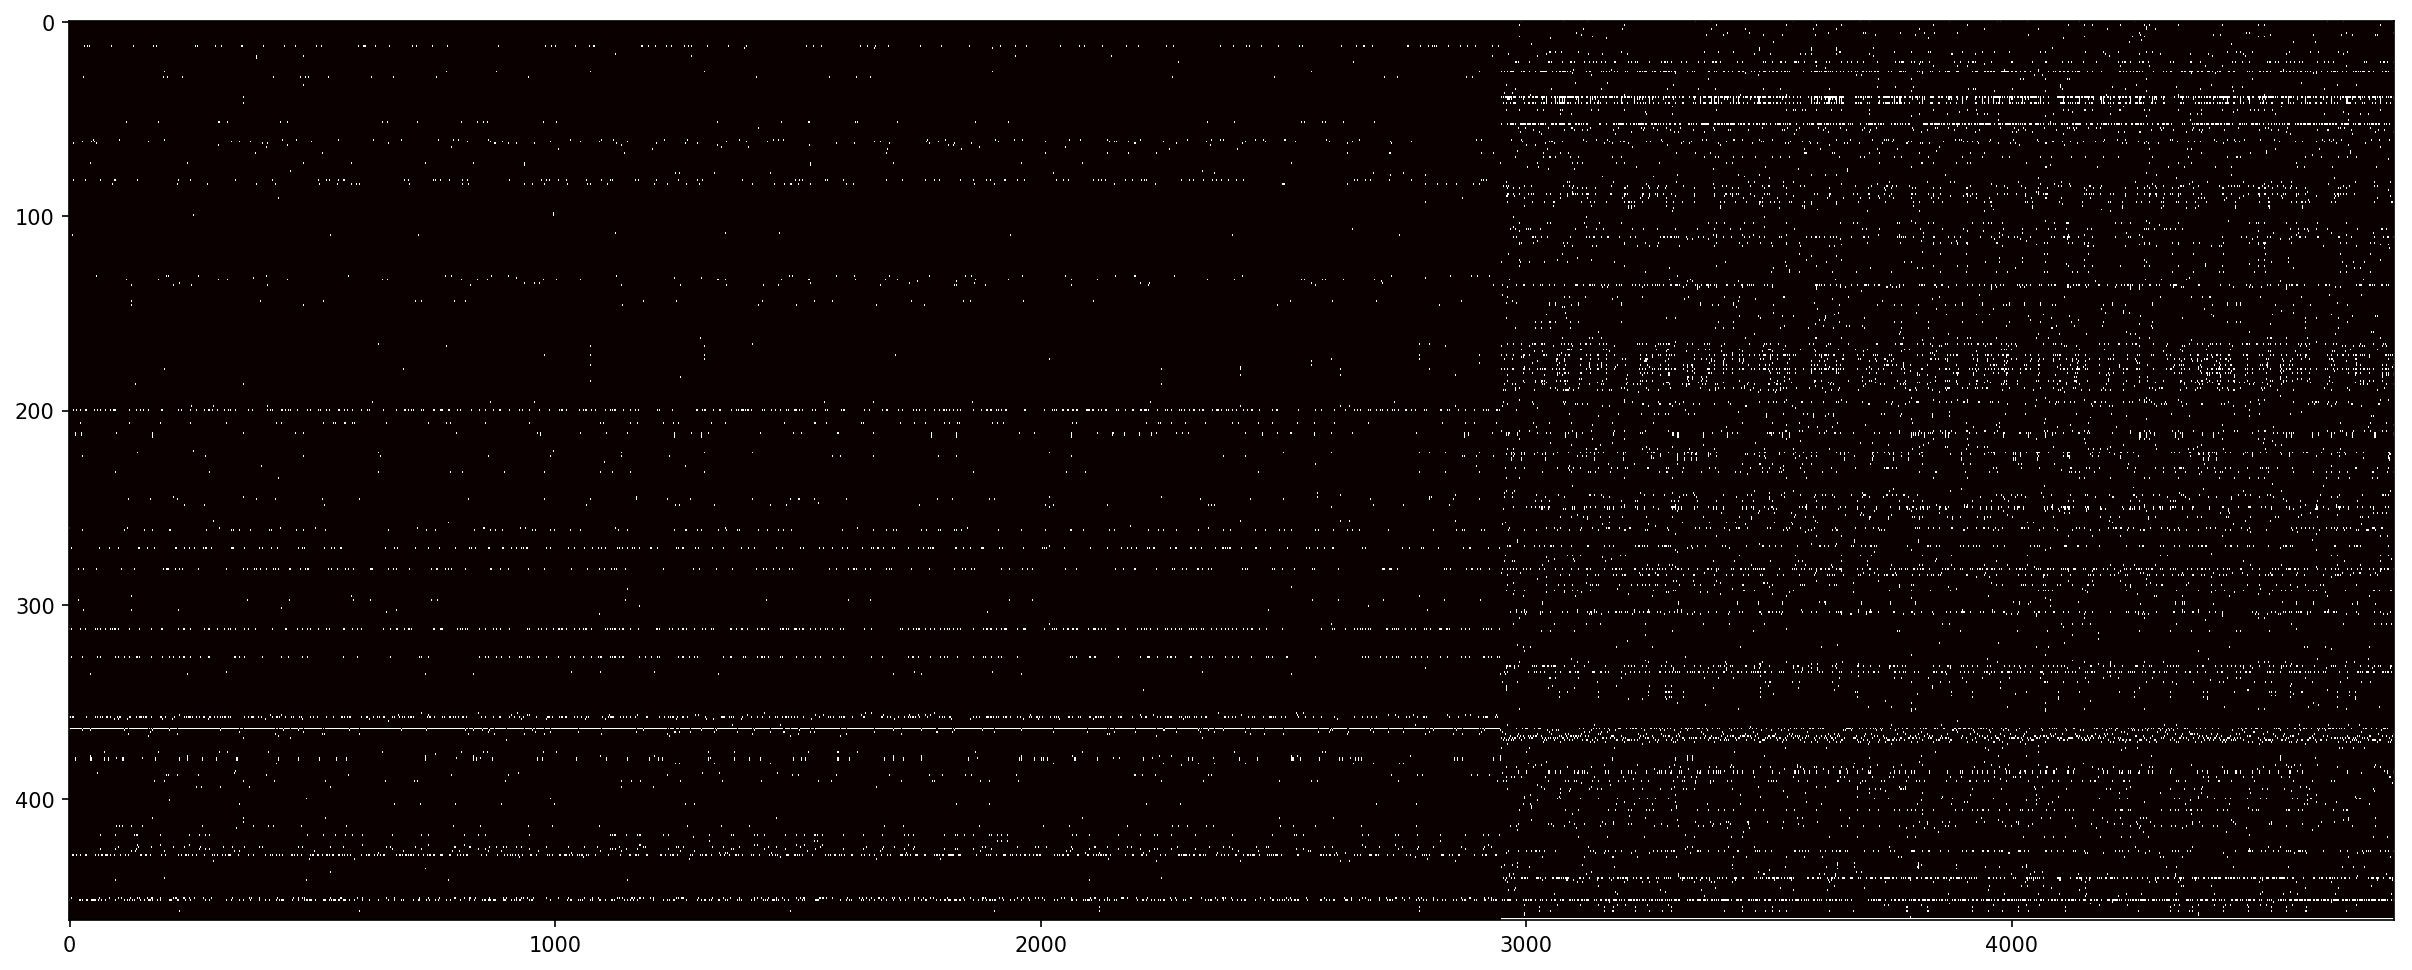

In [2]:
input_file = "./dane_dm/spam.dat"
data = load_df_from_csv(input_file)
heatmap(data)

## 3. Redukcja cech

Kolejnym krokiem jest redukcja wymiarowości. Pierwsza instrukcja w poniższym kodzie odnosi się jednak do czegoś innego - jest ona odpowiedzialna za "oversampling" sztuczne zwiększenie (powielenie) liczby próbek danego rodzaju (rodzaj można przekazać w parametrze, domyślnie jest to 0 - nie-spam). Tutaj, taki zabieg ma głownie na celu korekcję jednego rodzaju błędu, w którym listy nie będące spamem rozpoznamy jako spam - sztucznie zwiększając zwykłe wiadomości sprawimy, że klasyfikatory będą chciały chętniej wybierać daną klasę. Ten sam efekt można osiągnąć poprzez ustalenie wag dla każdej z klasy na wejściu algorytmu, jednak nie każda z wybranych metod ma tę możliwość. Parametr "ratio" mówi ilukrotnie należy zwiększyć reprezentantów danej klasy, parametr "n_components" ile cech ma zwrócić na wyjściu (nieistotny dla "VarianceThreshold"), a parametr "threshold" mówi o progu wariancji dla metody "VarianceThreshold".

Dalej, widzimy funkcję odpowiedzialną za redukcję wymiarów. Do wyboru mamy trzy (właściwie cztery) metody redukcji:

- RFE - domyślnie korzysta z DecisionTreeClassifier do wyboru cech,
- SelectKBest - korzystając z testu zgodności chi-kwadrat wybiera k najlepszych cech,
- VarianceThreshold - odrzuca wszystkie cechy, których wariancja jest mniejsza niż zadany próg (dla wartości powinno odrzucać te cechy, których znakomita większość ma jedną z wartości),
- PCA - nie jest to metoda selekcji cech (jak te powyższe) a redukcji wymiarowości (stąd osobna funkcja "get_reduced_dimension"). Tworzy zadaną liczbę nowych wartości będących kombinacją tych poprzednich. Tutaj jest wykorzystywana raczej do wizualizacji 2D

Ostatnie dwie linijki odpowiadają za wyświetlnie oryginalnych danych - jest to element zbędny ale pozwalający lepiej je zrozumieć. Już na tym etapie warto pozmieniać parametry funkcji "get_selected_features" (lub wykomentować ją całkowicie) i obserwować jak będzie się zmieniać wykres.

(4789, 462)
(4789, 75)


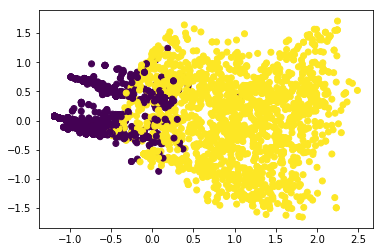

In [3]:
target = data.pop("target")
print(data.shape)
data = get_selected_features(data, target, "kbest", n_components=75, threshold=0.1)
print(data.shape)
cor = get_reduced_dimension(data)
scatter_plot(cor.values[:, 0], cor.values[:, 1], target)
data["target"] = target

## 4. Uczenie modeli

Pierwszym krokiem przed przystąpieniem do samego uczenia jest podział danych na dwa zbiory - zbiór uczący i zbiór testowy.  Parametr "[0.8]" określa punkt podziału (od 0% do 80% jako jedna część, od 80% do 100% jako druga). Ta funkcja pozwala podzielić zbiór na więcej niż dwie części, więc możliwe jest uzyskanie również części walidacyjnej, jednak tutaj jest ona zbędna (o czym za chwilę).

In [4]:
data, test = split_data(data, [0.8])
#  data = get_oversampled_data(data, label=0, ratio=10)
target = data.pop("target")
test_target = test.pop("target")

Tworzymy listę modeli i dla każdego z nich uruchamiamy metodę "train" (MLPModel uczy się najdłużej). Ostatni parametr odpowiada na pytanie czy przy trenowaniu modelu należy użyć "Cross-validation" (uwaga, parametry wejściowe zostały już w ten sposób dobrane - przekazując flagę "False" zaoszczędzimy czasu, jednak zmieniając dane uczące możemy nie otrzymać optymlnego wyniku). Przyjrzyjmy się na przykład klasie "NaiveBayesModel".

```
from sklearn.naive_bayes import MultinomialNB
from src.model.base import BaseModel


class NaiveBayesModel(BaseModel):

    def __init__(self):
        super(NaiveBayesModel, self).__init__()
        self.model = MultinomialNB()
        self.tuned_parameters = {"alpha": [0.01, 0.1, 0.25, 0.5, 0.75, 1]}

```

W definicji widzimy atrybut "tuned_parameters", który zawiera listę możliwych parametrów dla uczonego modelu. Każda z możliwości będzie sprawdzona (dzięki walidacji krzyżowej), a następnie zostanie wybrana najlepsza z nich. Dzięki takiemu podejściu nie musimy dzielić zbioru wejściowego na trzy części przez co więcej danych bierze udział w uczeniu.

![CrossValidation](images/K-fold_cross_validation_EN.jpg)

In [5]:
models = [NaiveBayesModel(), SVMModel(), DecisionTreeModel(), MLPModel()]
for m in models:
    m.train(data, target, True)

{'alpha': 0.75}
{'C': 10, 'kernel': 'rbf'}
{'min_samples_split': 82}


/home/gobr/projects/Hurtownie/part2/DataWarehouseingProject/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/gobr/projects/Hurtownie/part2/DataWarehouseingProject/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/gobr/projects/Hurtownie/part2/DataWarehouseingProject/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/gobr/projects/Hurtownie/part2/DataWarehouseingProject/venv/lib/python3.6/site-package

{'activation': 'relu'}


/home/gobr/projects/Hurtownie/part2/DataWarehouseingProject/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## 5. Analiza jakości klasyfikatorów

Ostatni i najważniejszy z etapów projektu - ocena jakości i porównanie klasyfikatorów. Zacznijmy od ogólnego raportu i macierzy błędu (poniższe rysunki pomogą go zrozumieć).

<img src="images/prec.png" style="float: left; width: 30%; margin-right: 1%; margin-left: 20%; margin-bottom: 0.5em;">
<img src="images/sens.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

NaiveBayesModel
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       613
           1       0.95      0.97      0.96       345

   micro avg       0.97      0.97      0.97       958
   macro avg       0.97      0.97      0.97       958
weighted avg       0.97      0.97      0.97       958



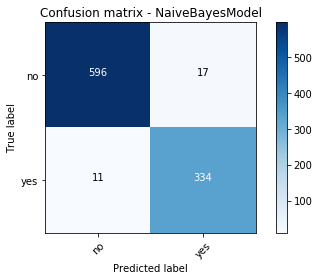

SVMModel
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       613
           1       1.00      0.95      0.97       345

   micro avg       0.98      0.98      0.98       958
   macro avg       0.99      0.98      0.98       958
weighted avg       0.98      0.98      0.98       958



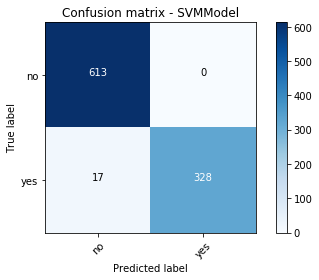

DecisionTreeModel
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       613
           1       0.98      0.95      0.96       345

   micro avg       0.97      0.97      0.97       958
   macro avg       0.98      0.97      0.97       958
weighted avg       0.97      0.97      0.97       958



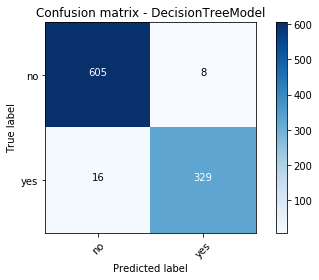

MLPModel
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       613
           1       1.00      0.96      0.98       345

   micro avg       0.99      0.99      0.99       958
   macro avg       0.99      0.98      0.98       958
weighted avg       0.99      0.99      0.99       958



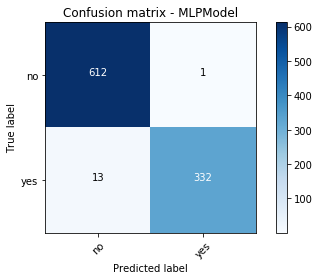

In [6]:
results = {m.__class__.__name__: m.predict(test) for m in models}

for k, v in results.items():  
    print(k)
    print(get_classification_report(test_target, v))
    cm = get_confusion_matrix(test_target, v)
    plot_confusion_matrix(cm, ["no", "yes"], title = "Confusion matrix - {}".format(k))

Wyżej widać, że wszyskie klasyfikatory radzą sobie naprawdę dobrze.
Dla poprawienia ogólnych wyników można zmieniać próbować jeszcze zmieniać ilość wybranych cech i same parametry klasyfikatora,
jednak dla takich ustawień metody zachowują się naprawdę dobrze. Jedną z cech jaka może nas interesować jest redukcja błędu
FP (fałszywie pozytywny) - nie chcemy, żeby jakaś wiadomość niebędąca spamem została jako taki zakwalifikowana.
Jak było to mówione wyżej można ten problem rozwiązać zwiększając liczbę próbek oznaczonych jako zwykłe wiadomości
(można odkomentować linijkę wyżej) pogorszy to ogólną sprawność klasyfikatora, ale będzie on lepiej przystosowany do sytuacji.

Jeżeli chcieć prównywać metody między sobą to najwygodniej to zrobić patrząc nakrzywą ROC.

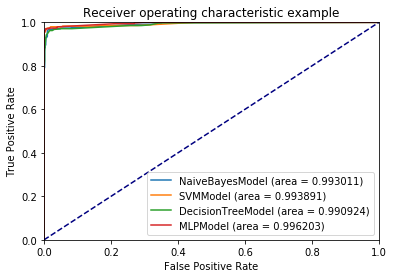

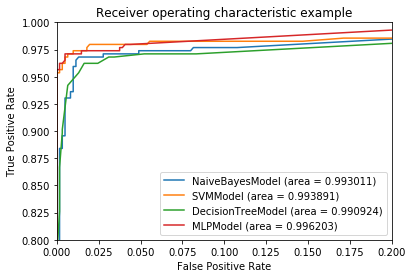

In [7]:
fpr_list = []
tpr_list = []
auc_list = []

for m in models:
    y_score = m.decision_function(test)[:, 1]
    fpr, tpr = get_roc_curve(test_target, y_score)
    auc = get_auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)


curve_plot(fpr_list, tpr_list, auc_list, list(results.keys()))
curve_plot(fpr_list, tpr_list, auc_list, list(results.keys()), x=[0.0, 0.2], y=[0.8, 1.0])


Jak widać na powyższym wykresie wszystkie klasyfikatory mają bardzo wysoką czułość (True Positive Rate), jednak najlepszy punkt równowagi jest dla MLPModel i SVMModel. Najgorzej poradził sobie algorytm naiwnego Bayesa (uwaga, zmieniając odpowiednio liczbę cech drzewo decyzyjne możne zamienić się miejscami z NaiveBayesModel).


## 6. Wnioski

Najpierw o narzędziu - sklearn jest świetną biblioteką z ogromem funkcji i genialną dokumentacją
(zawierającą również wiele elementów teoretycznych). Jupyter jest bardzo wygodny i estetyczny, a możliwość generowania
raportów w locie niezastąpiona. Znacznie ułatwia pracę, zwłaszcza w zespołach. Dodatkowo pozwala w łatwy sposób dzielić się wiedzą.

Ogrom narzędzi i metod w nauczaniu maszynowym potrafi przytłoczyć i ciężko jest jednoznacznie stwierdzić, która droga jest najlepsza.
Ciężko jest jednoznacznie stwierdzić, że jakiś algorytm nada się najlepiej do danego typu danych, stąd potrzeba eksperymentów i "kombinowania". Jeżeli chodzi o same dane użyte do tego projektu to byłem zaskoczony jak dobrze te klasyfikatory się uczą. Nawet znacznie zmniejszając zbiór uczący można uzyskać nienajgorsze wyniki. Dopiero gdy obejrzałem wejściową macierz w formie mapy cieplnej stało się dla mnie jasne czemu tak się dzieje -kilka silnie skorelowanych cech sprawia, że o większość dobrze zaklasyfikowanych próbek nie trzeba walczyć - to te kilka pozostałych procent ma największe znacznie.